In [1]:
import numpy as np
from termcolor import colored
import stim
import itertools as itt
import random
import warnings
import galois
import qecc as qc
import random
from pymatching import Matching

### Steps to do:
- Encoder (done)
- Decoder
- Approximate logical error rate (needs refinement)

### things to improve:
- Right now, the encoder looks for all solutions, while we need just one good Clifford
- Formalize a way to quantify the expected error and uncertainty 
- Would be good to convert to stim, as stim is probably faster than quaec
- probably can further optimize steps in the algo. 

### Steps for algo:

[0]
- Sample from error set 
- form the error set into a set of weighted check operators

[1]
- Color a face
- extract stabilizers
- calculate new decoder 
- verify action on check operators
- determine p_logical

Conventions: 

- X coords extend vertically |
- Z coords extend horizontally -

(same as in the 2D compass codes paper)

In [2]:
class Lattice_2d():
    def __init__(self, dimX, dimZ):
        self._dimX = dimX
        self._dimZ = dimZ
        self._colors = ['I'] * (dimX-1)*(dimZ-1)
        self._stabs = self.bacon_shor_group()
        self._gauge = self.elem_gauge_group()
        self._Lx = ['X']*dimX+['I']*dimX*(dimZ-1)
        self._Lz = (['Z']+['I']*(dimX-1))*dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self._dimX
        dimZ = self._dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self._colors[i*(dimZ-1) + j] == 'R'):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self._colors[i*(dimZ-1) + j] == 'B'):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self._colors[i*(dimZ-1) + j] == 'I'):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self._colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self._dimX*self._dimZ
    
    def getG(self):
        return self._gauge[0]+self._gauge[1]
    
    def getGx(self):
        return self._gauge[0]
    
    def getGz(self):
        return self._gauge[1]
    
    def getS(self):
        return self._stabs[0]+self._stabs[1]
    
    def getSx(self):
        return self._stabs[0]
    
    def getSz(self):
        return self._stabs[1]
    
    def getDims(self):
        return (self._dimX, self._dimZ)
        
    def bacon_shor_group(self):
        Xs = []
        Zs = []
        dimX = self._dimX
        dimZ = self._dimZ
        for i in range(dimZ-1):
            s = list('I'*dimZ*dimX)
            for j in range(dimX):
                s[j*dimZ+i] = 'Z'
                s[j*dimZ+i+1] = 'Z'
            Zs.append(''.join(s))
        for i in range(dimX-1):
            s = list('I'*dimX*dimZ)
            for j in range(dimZ):
                s[j+i*dimZ] = 'X'
                s[j+(i+1)*dimZ] = 'X'
            Xs.append(''.join(s))
        return [Xs, Zs]
    
    def elem_gauge_group(self):
        Xs = []
        Zs = []
        dimX = self._dimX
        dimZ = self._dimZ
        # make X-type gauge ops
        for i in range(0, dimZ):
            for j in range(dimX-1):
                s = list('I'*dimX*dimZ)
                s[i+j*dimZ] = 'X'
                s[i+(j+1)*dimZ] = 'X'
                Xs.append(''.join(s))
        # make Z-type gauge ops
        for j in range(dimZ-1):
            for i in range(0, dimX): 
                s = list('I'*dimX*dimZ)
                s[i*dimZ+j] = 'Z'
                s[i*dimZ+j+1] = 'Z'
                Zs.append(''.join(s))
        return [Xs, Zs]
    
    def display(self, pauli):
        dimX = self._dimX
        dimZ = self._dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Stabilizer dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self._dimX
        dimZ = self._dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        
        
        if cut_type == 'R':
            # R is a Z-cut
            g = ['I'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['I'] * dimX*dimZ
                    s2 = ['I'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['I'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[i + k*dimZ] = 'Z'
                gauge[i + k*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == 'B':
            # B is a X-cut:
            g = ['I'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['I'] * dimX*dimZ
                    s2 = ['I'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimX):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['I'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self._stabs = [Sx, Sz]
        self._gauge = [Gx, Gz]
        
    def encoder(self):
        """
        make a canonical clifford operator for a subsystem code
    
        convention: 
            logical qubits are the first len(lXs) qubits, 
            stabilizer qubits are the next len(stabs) qubits
            gauges are the last len(gauges) qubits
        """
        S = self.getS()
        lX = ''.join(self._Lx)
        lZ = ''.join(self._Lz)
        
        x_basis = []
        z_basis = []
        x_basis.append(qc.Pauli(lX))
        z_basis.append(qc.Pauli(lZ))
        for s in S:
            z_basis.append(qc.Pauli(s))
            x_basis.append(qc.Unspecified)
        for _ in range(len(S[0]) - len(S) - 1):
            x_basis.append(qc.Unspecified)
            z_basis.append(qc.Unspecified)
        return next(qc.Clifford( x_basis, z_basis).constraint_completions())
        
        
    def color_face(self, coords, cut_type):
        (x, z) = coords
        if (x >= self._dimX-1) or (z >= self._dimZ-1):
            raise ValueError(f'Face coordinant ({x}, {z}) out of lattice range')
        self._colors[x*(self._dimZ-1) + z] = cut_type
        self.update_groups(coords, cut_type)


In [3]:
def pauli_weight(pauli):
    """Get weight of pauli operator"""
    if type(pauli) is list:
        pvec = np.array(pauli)
    elif type(pauli) is str:
        pvec = pauli2vector(pauli)
    else:
        pvec = pauli
    return np.sum(np.bitwise_or(pvec[:int(len(pvec)/2)], pvec[int(len(pvec)/2):]))

In [4]:
def pauli2binary(pstr):
    """
    convert pstr to a binary vector
    """
    bstr = [0]*2*len(pstr)
    for idx, c in enumerate(pstr):
        if c == 'X':
            bstr[idx] = 1
        elif c == 'Z':
            bstr[idx+len(pstr)] = 1
        elif c == 'Y':
            bstr[idx] = 1
            bstr[idx+len(pstr)] = 1
    return bstr

def pauli2vector(pstr):
    """
    convert pstr to a binary vector
    """
    bstr = [0]*2*len(pstr)
    for idx, c in enumerate(pstr):
        if c == 'X':
            bstr[idx] = 1
        elif c == 'Z':
            bstr[idx+len(pstr)] = 1
        elif c == 'Y':
            bstr[idx] = 1
            bstr[idx+len(pstr)] = 1
    return np.array(bstr)

def binary2pauli(blst):
    """
    convert binary list to Pauli string
    """
    L = int(len(blst)/2)
    pstr = []
    for l in range(L):
        if blst[l] == 0 and blst[l+L] == 0:
            pstr.append('I')
        elif blst[l] == 1 and blst[l+L] == 0:
            pstr.append('X')
        elif blst[l] == 0 and blst[l+L] == 1:
            pstr.append('Z')
        elif blst[l] == 1 and blst[l+L] == 1:
            pstr.append('Y')
    return ''.join(pstr)

In [5]:
def twisted_product(stab_binary, pauli_binary):
    """
    take twisted product of stabilizer with pauli to calculate commutator 
    """
    L = int(len(stab_binary)/2)
    return (stab_binary[:L]@pauli_binary[L:] + stab_binary[L:]@pauli_binary[:L]) % 2

In [6]:
def parity_check(stabs, pauli):
    if len(stabs) == 0:
        return np.array([0])
    if type(pauli[0]) is str:
        bvec = pauli2vector(pauli)
    else: 
        bvec = pauli
    if type(stabs[0]) is str:
        return np.array([twisted_product(pauli2vector(s), bvec) for s in stabs])
    else:
        return np.array([twisted_product(s, bvec) for s in stabs])

In [7]:
def pauli_group(qubits):
    """
    generate Pauli group in n-qubits in strings
    """
    return [''.join(p) for p in itt.product('IXYZ', repeat=qubits)]

def paulis_weighted(qubits, weight):
    """
    generate all Pauli operators of weight <= weight
    """
    gen = [('I',)*qubits]
    for i in range(1, weight+1):
        gen = itt.chain(gen, itt.product('XYZ', repeat=i))
    basic_strings = [g+('I',)*(qubits-len(g)) for g in gen]
    paulis = set()
    for b in basic_strings:
        for p in itt.permutations(b):
            paulis.add(''.join(p))
    return paulis

def pauli_band(qubits, weight):
    """
    generated all Pauli operators of weight == weight
    """
    assert weight < qubits, "invalid band"
    basic_strings = [g+('I',)*(qubits-weight) for g in itt.combinations_with_replacement('XYZ', weight)]
    paulis = set()
    for b in basic_strings:
        for p in itt.permutations(b):
            paulis.add(''.join(p))
    return paulis

In [8]:
def pauli2tableau(pstr):
    tout = stim.Tableau(len(pstr))
    for idx, p in enumerate(pstr):
        tout.append(stim.Tableau.from_named_gate(p), [idx])
    return tout

In [9]:
def sample_globalbias(qubits, rx, ry, rz, N):
    """
    sample error distribution with rx, ry, rz dephasing
    """
    assert rx+ry+rz <= 1, "dephasing rates > 1"
    hist = dict()
    for n in range(N):
        e = []
        for q in range(qubits):
            s = random.uniform(0, 1)
            if 0 <= s < rx:
                e.append('X')
            elif rx <= s < rx+ry:
                e.append('Y')
            elif rx+ry <= s < rx+ry+rz:
                e.append('Z')
            else:
                e.append('I')
        estr = ''.join(e)
        if estr not in hist:
            hist[estr] = 1/N
        else:
            hist[estr] += 1/N
    return hist

In [10]:
def check_distribution_globalbias(qubits, wt_min, wt_max, rx, ry, rz, N):
    """
    sample from global biased noise model and
    partition into a group of error checks along with rates below and above wt_min and wt_max
    """
    assert rx+ry+rz <= 1, "dephasing rates > 1"
    hist = dict()
    amp_below = 0
    amp_above = 0
    for n in range(N):
        e = []
        for q in range(qubits):
            s = random.uniform(0, 1)
            if 0 <= s < rx:
                e.append('X')
            elif rx <= s < rx+ry:
                e.append('Y')
            elif rx+ry <= s < rx+ry+rz:
                e.append('Z')
            else:
                e.append('I')
        estr = ''.join(e)
        wt = pauli_weight(estr)
        if (wt_min <= wt) and (wt <= wt_max):
            if estr not in hist:
                hist[estr] = 1/N
            else:
                hist[estr] += 1/N
        elif wt < wt_min:
            amp_below += 1/N
        elif wt > wt_max: 
            amp_above += 1/N
    return [hist, amp_below, amp_above]

In [11]:
def is_logical_error(enc, pauli):
    """
    check if given pauli causes a logical error
    """
    qubits = pauli.nq
    xeff = qc.Pauli(''.join(['X']+['I']*(qubits-1)))
    zeff = qc.Pauli(''.join(['Z']+['I']*(qubits-1)))
    effect = enc.inv() * pauli.as_clifford() * enc
    if(
        effect.conjugate_pauli(xeff) == xeff and
        effect.conjugate_pauli(zeff) == zeff
    ):
        return False
    else:
        return True

In [12]:
def make_lookup(stabs, encoder, max_weight=None):
    """
    make a lookup decoder 
    for all Pauli errors of weight <= max_weight
    only add a syndrome if it has not already been mapped to an error
    """
    if max_weight is None:
        max_weight = len(stabs[0])
    dict_out = dict()
    weight = 0
    measurements = make_syndrome_basis(len(stabs[0]), len(stabs))
    dec = encoder.inv()

    while(len(dict_out) < 2**len(stabs) and weight < max_weight):
        eset = pauli_band(len(stabs[0]), weight)
        for e in eset:
            effect = dec * qc.Pauli(e).as_clifford() * encoder
            syndrome = tuple(effect.conjugate_pauli(qc.Pauli(meas)).ph /2 for meas in measurements)
            if syndrome not in dict_out:
                dict_out[syndrome] = e
        weight += 1
    return dict_out

In [13]:
def make_syndrome_basis(qubits, syndromes, logicals=1):
    """
    make syndrome measurement operators 
    assume order is logicals, then syndromes, then gauges 
    """
    sout = []
    for s in range(syndromes):
        syn = ['I']*qubits
        syn[s+1] = 'Z'
        sout.append(syn)
    return [''.join(s) for s in sout]

In [14]:
make_syndrome_basis(6, 3)

['IZIIII', 'IIZIII', 'IIIZII']

In [15]:
lat = Lattice_2d(3,3)
lat.color_face((0,0), 'R')
lat.color_face((1,0), 'B')
lat.color_face((0,1), 'R')
lat.color_face((1,1), 'B')
enc = lat.encoder()
Sx, Sz = lat._stabs[0], lat._stabs[1]
dic = make_lookup(Sx+Sz, enc)
dec = enc.inv()
measurements = make_syndrome_basis(len(Sx[0]), len(Sx+Sz))
logicalZ = 'Z'+'I'*(lat.size()-1)
logicalX = 'X'+'I'*(lat.size()-1)

In [23]:
[hist, amp_below, amp_above] = check_distribution_globalbias(9, 2, 6, 0.1, 0.1, 0.1, 10**4)
print(len(hist))
print(amp_above)

4409
0.0039999999999999975


In [17]:
r_failure = amp_above

for error in hist.keys():
    effect = dec * qc.Pauli(error).as_clifford() * enc
    syndrome = tuple([effect.conjugate_pauli(qc.Pauli(meas)).ph / 2 for meas in measurements])
    recovery = dic[syndrome]
    new_effect = dec * (qc.Pauli(recovery) * qc.Pauli(error)).as_clifford() * enc
    if (
        new_effect.conjugate_pauli(qc.Pauli(logicalX)).ph != 0 or
        new_effect.conjugate_pauli(qc.Pauli(logicalZ)).ph != 0
    ):
        # failure 
        r_failure += hist[error]
        
print(r_failure)

0.5083999999999745


In [18]:
lat = Lattice_2d(3,3)
lat.color_face((0,0), 'B')
print(lat)

000---001---002
 |  #  |     |
003---004---005
 |     |     |
006---007---008



In [19]:
for g in lat.getG():
    lat.display(g)

 X ---   ---   
 |     |     |    
 X ---   ---   
 |     |     |    
   ---   ---   

   ---   ---   
 |     |     |    
 X ---   ---   
 |     |     |    
 X ---   ---   

   --- X ---   
 |     |     |    
   --- X ---   
 |     |     |    
   ---   ---   

   ---   ---   
 |     |     |    
   --- X ---   
 |     |     |    
   --- X ---   

   ---   --- X 
 |     |     |    
   ---   --- X 
 |     |     |    
   ---   ---   

   ---   ---   
 |     |     |    
   ---   --- X 
 |     |     |    
   ---   --- X 

   ---   ---   
 |     |     |    
   ---   ---   
 |     |     |    
 Z --- Z ---   

   --- Z --- Z 
 |     |     |    
   ---   ---   
 |     |     |    
   ---   ---   

   ---   ---   
 |     |     |    
   --- Z --- Z 
 |     |     |    
   ---   ---   

   ---   ---   
 |     |     |    
   ---   ---   
 |     |     |    
   --- Z --- Z 



In [19]:
#we need to make the stabilizers into a Matching object
def stabs_to_mat(stabs):
    mat = np.array([[1 if i != 'I' else 0 for i in s] for s in stabs])
    return mat
        
def correction_to_string(vec, correction_type):
    #correction type is 'X' or 'Z'
    op = ''.join([correction_type if i==1 else 'I' for i in vec])
    return op

def mwpm_decode(Sx, Sz, syndrome):
    Hx = stabs_to_mat(Sx)
    mx = Matching(Hx)
    
    Hz = stabs_to_mat(Sz)
    mz = Matching(Hz)
    
    syndrome = [int(s) for s in syndrome]
    
    cx = correction_to_string(mx.decode(syndrome[:len(Sx)]), 'X')
    cz = correction_to_string(mz.decode(syndrome[len(Sx):]), 'Z')
    
    correction = qc.Pauli(cx)*qc.Pauli(cz)
    
    return correction
    

In [20]:
#here I have replaced the lookup decoder with the MWPM decoder
r_failure = amp_above

for error in hist.keys():
    effect = dec * qc.Pauli(error).as_clifford() * enc
    syndrome = tuple([effect.conjugate_pauli(qc.Pauli(meas)).ph / 2 for meas in measurements])
    recovery = mwpm_decode(Sx, Sz, syndrome)
    new_effect = dec * (recovery * qc.Pauli(error)).as_clifford() * enc
    if (
        new_effect.conjugate_pauli(qc.Pauli(logicalX)).ph != 0 or
        new_effect.conjugate_pauli(qc.Pauli(logicalZ)).ph != 0
    ):
        # failure
        r_failure += hist[error]
        
print(r_failure)

0.585499999999972


In [21]:
print(Sx, Sz)

['XXXXXXIII', 'IIIXIIXII', 'IIIIXIIXI', 'IIIIIXIIX'] ['ZZIIIIIII', 'IIIZZIZZI', 'IZZIIIIII', 'IIIIZZIZZ']


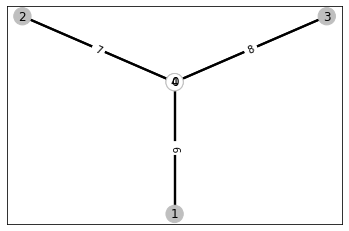

In [22]:
Matching(stabs_to_mat(Sx)).draw()

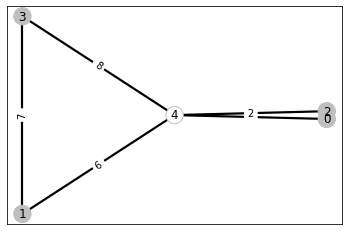

In [26]:
Matching(stabs_to_mat(Sz)).draw()